In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.8
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0059

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 535ms/step - loss: 0.0040
Average validation loss: 0.6334210634231567
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 546ms/step - loss: 0.0040 - val_loss: 0.6334
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 534ms/step - loss: 0.0026 - val_loss: 0.6334
Average validation loss: 0.4797554314136505
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 545ms/step - loss: 0.0026 - val_loss: 0.5566
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 525ms/step - loss: 0.0018 - val_loss: 0.5566
Average validation loss: 0.41627931594848633
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 534ms/step - loss: 0.0018 - val_loss: 0.5098
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segf

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 792ms/step - loss: 4.0544e-06
Average validation loss: 0.649106353521347
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 802ms/step - loss: 4.0544e-06 - val_loss: 0.6491
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 788ms/step - loss: 3.9520e-06 - val_loss: 0.6491
Average validation loss: 0.42139744758605957
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 798ms/step - loss: 3.9520e-06 - val_loss: 0.5353
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 793ms/step - loss: 3.9335e-06 - val_loss: 0.5353
Average validation loss: 0.316501222550869
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 803ms/step - loss: 3.9335e-06 - val_loss: 0.4623
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_se

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 804ms/step - loss: 4.8688e-06
Average validation loss: 0.3356621339917183
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 813ms/step - loss: 4.8688e-06 - val_loss: 0.3357
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 781ms/step - loss: 4.3859e-06 - val_loss: 0.3357
Average validation loss: 0.24375430370370546
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 791ms/step - loss: 4.3859e-06 - val_loss: 0.2897
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 780ms/step - loss: 4.1467e-06 - val_loss: 0.2897
Average validation loss: 0.1186889298260212
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 788ms/step - loss: 4.1467e-06 - val_loss: 0.2327
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weigh

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 824ms/step - loss: 9.5149e-07
Average validation loss: 0.04755116440355778
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 837ms/step - loss: 9.5149e-07 - val_loss: 0.0476
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 811ms/step - loss: 7.6155e-07 - val_loss: 0.0476
Average validation loss: 0.03891048487275839
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 826ms/step - loss: 7.6155e-07 - val_loss: 0.0432
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 772ms/step - loss: 6.8650e-07 - val_loss: 0.0432
Average validation loss: 0.03195317927747965
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 784ms/step - loss: 6.8650e-07 - val_loss: 0.0395
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\wei

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 811ms/step - loss: 5.0220e-07
Average validation loss: 0.02222455069422722
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 821ms/step - loss: 5.0220e-07 - val_loss: 0.0222
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 806ms/step - loss: 4.2007e-07 - val_loss: 0.0222
Average validation loss: 0.021031505800783633
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 816ms/step - loss: 4.2007e-07 - val_loss: 0.0216
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 790ms/step - loss: 3.6934e-07 - val_loss: 0.0216
Average validation loss: 0.02079808251000941
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 800ms/step - loss: 3.6934e-07 - val_loss: 0.0214
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\we

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 781ms/step - loss: 3.6385e-07
Average validation loss: 0.01976450365812828
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 791ms/step - loss: 3.6385e-07 - val_loss: 0.0198
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 778ms/step - loss: 3.2996e-07 - val_loss: 0.0198
Average validation loss: 0.015026642436472079
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 788ms/step - loss: 3.2996e-07 - val_loss: 0.0174
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 781ms/step - loss: 2.8074e-07 - val_loss: 0.0174
Average validation loss: 0.013748431306642791
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 790ms/step - loss: 2.8074e-07 - val_loss: 0.0162
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\w

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 770ms/step - loss: 5.3124e-07
Average validation loss: 0.017264983023051173
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 779ms/step - loss: 5.3124e-07 - val_loss: 0.0173
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 767ms/step - loss: 4.6522e-07 - val_loss: 0.0173
Average validation loss: 0.021491290139965712
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 777ms/step - loss: 4.6522e-07 - val_loss: 0.0194
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 786ms/step - loss: 4.0011e-07 - val_loss: 0.0194
Average validation loss: 0.018184286262840032
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 796ms/step - loss: 4.0011e-07 - val_loss: 0.0190
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 125s 779ms/step - loss: 3.5608e-07 - val_loss: 0.0190
Average validation loss: 0.01465760653372854
40/40 ━━━━━━━━━━━━━━━━━━━━ 126s 789ms/step - loss: 3.5608e-07 - val_loss: 0.0179
Save

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 783ms/step - loss: 3.1600e-07
Average validation loss: 0.020022464217618108
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 794ms/step - loss: 3.1600e-07 - val_loss: 0.0200
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 783ms/step - loss: 2.3837e-07 - val_loss: 0.0200
Average validation loss: 0.020623987443589915
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 795ms/step - loss: 2.3837e-07 - val_loss: 0.0203
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 113s 772ms/step - loss: 2.0718e-07 - val_loss: 0.0203
Average validation loss: 0.010979763993721766
48/48 ━━━━━━━━━━━━━━━━━━━━ 114s 783ms/step - loss: 2.0718e-07 - val_loss: 0.0172
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_60.pth'.
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 154s 826ms/step - loss: 1

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 803ms/step - loss: 1.6546e-07
Average validation loss: 0.025246421141283854
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 815ms/step - loss: 1.6546e-07 - val_loss: 0.0252
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 819ms/step - loss: 1.3499e-07 - val_loss: 0.0252
Average validation loss: 0.012577810707235975
56/56 ━━━━━━━━━━━━━━━━━━━━ 92s 830ms/step - loss: 1.3499e-07 - val_loss: 0.0189
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 137s 796ms/step - loss: 1.2012e-07 - val_loss: 0.0189
Average validation loss: 0.012117412673043353
56/56 ━━━━━━━━━━━━━━━━━━━━ 137s 808ms/step - loss: 1.2012e-07 - val_loss: 0.0166
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0D

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 779ms/step - loss: 1.1546e-07
Average validation loss: 0.0210291487746872
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 791ms/step - loss: 1.1546e-07 - val_loss: 0.0210
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 100s 778ms/step - loss: 1.0666e-07 - val_loss: 0.0210
Average validation loss: 0.012322522539761849
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 789ms/step - loss: 1.0666e-07 - val_loss: 0.0167
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 151s 782ms/step - loss: 9.2546e-08 - val_loss: 0.0167
Average validation loss: 0.01332491694483906
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 794ms/step - loss: 9.2546e-08 - val_loss: 0.0156
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 202s 790ms/step - loss: 8.

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 776ms/step - loss: 8.0485e-08
Average validation loss: 0.01605129987971547
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 787ms/step - loss: 8.0485e-08 - val_loss: 0.0161
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 780ms/step - loss: 6.6163e-08 - val_loss: 0.0161
Average validation loss: 0.015069784596562386
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 791ms/step - loss: 6.6163e-08 - val_loss: 0.0156
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 779ms/step - loss: 5.9944e-08 - val_loss: 0.0156
Average validation loss: 0.01883996962634329
72/72 ━━━━━━━━━━━━━━━━━━━━ 171s 791ms/step - loss: 5.9944e-08 - val_loss: 0.0167
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 227s 777ms/step - loss: 5

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 779ms/step - loss: 1.0572e-07
Average validation loss: 0.01275995650794357
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 789ms/step - loss: 1.0572e-07 - val_loss: 0.0128
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 126s 790ms/step - loss: 8.8142e-08 - val_loss: 0.0128
Average validation loss: 0.009969578549498693
80/80 ━━━━━━━━━━━━━━━━━━━━ 127s 801ms/step - loss: 8.8142e-08 - val_loss: 0.0114
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 190s 781ms/step - loss: 7.2451e-08 - val_loss: 0.0114
Average validation loss: 0.009584002394694835
80/80 ━━━━━━━━━━━━━━━━━━━━ 191s 792ms/step - loss: 7.2451e-08 - val_loss: 0.0108
Saved model weights to 'c:\天_11157065\git\RipplesDetection\a

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 780ms/step - loss: 1.1494e-07
Average validation loss: 0.018800230919926737
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 790ms/step - loss: 1.1494e-07 - val_loss: 0.0188
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 151s 782ms/step - loss: 9.2870e-08 - val_loss: 0.0188
Average validation loss: 0.015529300333582796
96/96 ━━━━━━━━━━━━━━━━━━━━ 152s 793ms/step - loss: 9.2870e-08 - val_loss: 0.0172
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 228s 788ms/step - loss: 8.0186e-08 - val_loss: 0.0172
Average validation loss: 0.01949884428177029
96/96 ━━━━━━━━━━━━━━━━━━━━ 229s 799ms/step - loss: 8.0186e-08 - val_loss: 0.0179
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 305s 798ms/step - loss

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 94s 785ms/step - loss: 2.5880e-07
Average validation loss: 0.012793967923304688
120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 796ms/step - loss: 2.5880e-07 - val_loss: 0.0128
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 191s 792ms/step - loss: 2.2623e-07 - val_loss: 0.0128
Average validation loss: 0.016892582007373372
120/120 ━━━━━━━━━━━━━━━━━━━━ 192s 803ms/step - loss: 2.2623e-07 - val_loss: 0.0148
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 287s 788ms/step - loss: 1.9168e-07 - val_loss: 0.0148
Average validation loss: 0.01672223557640488
120/120 ━━━━━━━━━━━━━━━━━━━━ 288s 799ms/step - loss: 1.9168e-07 - val_loss: 0.0155
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 382s 786ms/step - loss: 1.6793e-07 - val_loss: 0.0155
Average validation loss: 0.017898288330373664
120/120 ━━━━━━━━━━━━━━━━━━━━ 384s 797ms/step - loss: 1.6793e-07 - 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 112s 781ms/step - loss: 1.8735e-07
Average validation loss: 0.017264494413716927
144/144 ━━━━━━━━━━━━━━━━━━━━ 114s 792ms/step - loss: 1.8735e-07 - val_loss: 0.0173
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 227s 784ms/step - loss: 1.6345e-07 - val_loss: 0.0173
Average validation loss: 0.020359198640411098
144/144 ━━━━━━━━━━━━━━━━━━━━ 229s 795ms/step - loss: 1.6345e-07 - val_loss: 0.0188
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 341s 778ms/step - loss: 1.3902e-07 - val_loss: 0.0188
Average validation loss: 0.015684940105226513
144/144 ━━━━━━━━━━━━━━━━━━━━ 342s 789ms/step - loss: 1.3902e-07 - val_loss: 0.0178
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_180.pth'.
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 455s 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 778ms/step - loss: 1.1639e-07
Average validation loss: 0.018999054637970404
160/160 ━━━━━━━━━━━━━━━━━━━━ 126s 790ms/step - loss: 1.1639e-07 - val_loss: 0.0190
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 251s 776ms/step - loss: 9.1108e-08 - val_loss: 0.0190
Average validation loss: 0.025187179108615964
160/160 ━━━━━━━━━━━━━━━━━━━━ 252s 787ms/step - loss: 9.1108e-08 - val_loss: 0.0221
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 377s 777ms/step - loss: 7.7801e-08 - val_loss: 0.0221
Average validation loss: 0.02391437611950096
160/160 ━━━━━━━━━━━━━━━━━━━━ 378s 787ms/step - loss: 7.7801e-08 - val_loss: 0.0227
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 503s 781ms/step - loss: 7.0485e-08 - val_loss: 0.0227
Average validation loss: 0.022505129236378707
160/160 ━━━━━━━━━━━━━━━━━━━━ 505s 791ms/step - loss: 7.0485e-08 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 158s 791ms/step - loss: 1.4286e-07
Average validation loss: 0.02026963425334543
200/200 ━━━━━━━━━━━━━━━━━━━━ 160s 801ms/step - loss: 1.4286e-07 - val_loss: 0.0203
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 319s 791ms/step - loss: 1.1335e-07 - val_loss: 0.0203
Average validation loss: 0.01806083986768499
200/200 ━━━━━━━━━━━━━━━━━━━━ 321s 802ms/step - loss: 1.1335e-07 - val_loss: 0.0192
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 477s 781ms/step - loss: 9.8301e-08 - val_loss: 0.0192
Average validation loss: 0.02232410553377122
200/200 ━━━━━━━━━━━━━━━━━━━━ 479s 792ms/step - loss: 9.8301e-08 - val_loss: 0.0202
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 637s 786

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 187s 781ms/step - loss: 8.8511e-08
Average validation loss: 0.010412967511607954
240/240 ━━━━━━━━━━━━━━━━━━━━ 190s 792ms/step - loss: 8.8511e-08 - val_loss: 0.0104
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 378s 781ms/step - loss: 7.5739e-08 - val_loss: 0.0104
Average validation loss: 0.01540557482027604
240/240 ━━━━━━━━━━━━━━━━━━━━ 380s 792ms/step - loss: 7.5739e-08 - val_loss: 0.0129
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 564s 767ms/step - loss: 6.5095e-08 - val_loss: 0.0129
Average validation loss: 0.016344394385426616
240/240 ━━━━━━━━━━━━━━━━━━━━ 567s 778ms/step - loss: 6.5095e-08 - val_loss: 0.0141
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 754s 778ms/step - loss: 5.8071e-08 - val_loss: 0.0141
Average validation loss: 0.018014654320237848
240/240 ━━━━━━━━━━━━━━━━━━━━ 756s 789ms/step - loss: 5.8071e-08 

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.21893350645899773, 0.1412630831077695, 0.07833398687342802, 0.022254903388093227, 0.014647099237423388, 0.012756107394040251, 0.013781575458240693, 0.013101382178526062, 0.014986199274842096, 0.011090462546562777, 0.011341253738210069, 0.010652534714812645, 0.011729162814517625, 0.01802740876756919, 0.017974163453287072, 0.018696334328022205, 0.01895255797439022, 0.01655490514214034]
std_val_losses =  [0.1450837410651632, 0.1140029263601947, 0.060820043007522445, 0.007813700651335785, 0.00545654192883276, 0.004452328804592032, 0.005163806045355118, 0.006466712115200817, 0.03086704704335246, 0.004371033308515406, 0.0033794494058549404, 0.002527107190124209, 0.004296661297940858, 0.004220931713856187, 0.002676404153808089, 0.003285364864367284, 0.0029879803023128205, 0.003295231735610477]


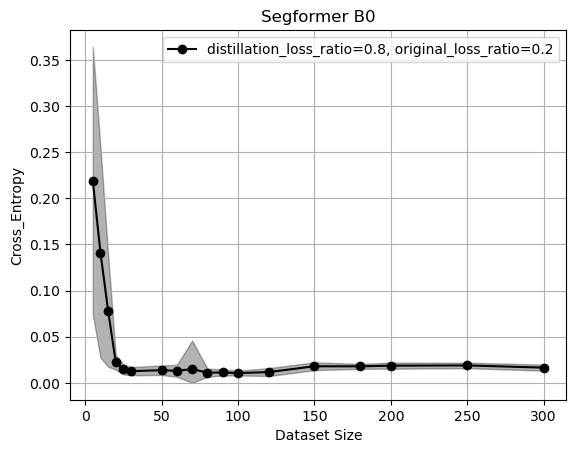

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()